In [2]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assignment3 Part2: Yolo Detection

We provide you a Yolo Detection network implementation, which is not finished. You are asked to complete the implementation by writing the loss function.

## What to do
You are asked to implement the loss function in ```yolo_loss.py```. You can use ```yolo_loss_debug_tool.ipynb``` to help you debug.

## What to submit
See the submission template for what to submit.

## Initialization

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effictively.

In [3]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/harddrive/.cache/torch/checkpoints/resnet50-19c8e357.pth


NameError: name 'device' is not defined

In [5]:
learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [6]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [7]:
file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [8]:
file_root_test = 'VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


## Train detector

In [9]:
best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'detach_best_detector.pth')

    torch.save(net.state_dict(),'detach_detector'+str(epoch+1)+'.pth')
    if (epoch+1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test)
        np.save("detach_aps_"+str(epoch+1), test_aps)
    




Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [5/209] Loss: 67.7673, average_loss: 68.5211
Epoch [1/50], Iter [10/209] Loss: 40.2418, average_loss: 59.5417
Epoch [1/50], Iter [15/209] Loss: 26.5193, average_loss: 50.2207
Epoch [1/50], Iter [20/209] Loss: 15.6932, average_loss: 42.7062
Epoch [1/50], Iter [25/209] Loss: 12.5974, average_loss: 37.1865
Epoch [1/50], Iter [30/209] Loss: 12.5024, average_loss: 33.2728
Epoch [1/50], Iter [35/209] Loss: 13.0251, average_loss: 30.1399
Epoch [1/50], Iter [40/209] Loss: 9.4308, average_loss: 27.6054
Epoch [1/50], Iter [45/209] Loss: 8.3512, average_loss: 25.8050
Epoch [1/50], Iter [50/209] Loss: 9.6077, average_loss: 24.2031
Epoch [1/50], Iter [55/209] Loss: 9.8284, average_loss: 22.7652
Epoch [1/50], Iter [60/209] Loss: 7.0618, average_loss: 21.6594
Epoch [1/50], Iter [65/209] Loss: 6.0822, average_loss: 20.6325
Epoch [1/50], Iter [70/209] Loss: 8.8267, average_loss: 19.6936
Epoch [1/50], Iter [75/209] Loss: 6.05

100%|██████████| 4950/4950 [03:48<00:00, 21.70it/s]


---class aeroplane ap 0.11629465892459062---
---class bicycle ap 0.1197368383526162---
---class bird ap 0.13834837725366178---
---class boat ap 0.004508419337316676---
---class bottle ap 0.023843963023687784---
---class bus ap 0.05335240914309701---
---class car ap 0.31335045547012136---
---class cat ap 0.027932960893854747---
---class chair ap 0.07472468355801666---
---class cow ap 0.04903227543137096---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.11636845712938644---
---class horse ap 0.2436726862303648---
---class motorbike ap 0.09580015333503705---
---class person ap 0.22555415643471574---
---class pottedplant ap 0.011851111310807572---
---class sheep ap 0.14121592497455393---
---class sofa ap 0.01785714285714286---
---class train ap 0.007239952718676123---
---class tvmonitor ap 0.17961406192756257---
---map 0.09801493441532903---


Starting epoch 6 / 50
Learning Rate for this epoch: 0.001
Epoch [6/50], Iter [5/209] Loss: 2.8161, average_loss: 3

100%|██████████| 4950/4950 [03:49<00:00, 21.57it/s]


---class aeroplane ap 0.2797038648004754---
---class bicycle ap 0.35255860527851834---
---class bird ap 0.34494632775978096---
---class boat ap 0.10181722891225248---
---class bottle ap 0.07537524671438368---
---class bus ap 0.22030127648778955---
---class car ap 0.500255435293031---
---class cat ap 0.37902195899706903---
---class chair ap 0.19617417335342557---
---class cow ap 0.27065033029010044---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.39582623583174215---
---class horse ap 0.473631974218284---
---class motorbike ap 0.4065674627147028---
---class person ap 0.40914844503835407---
---class pottedplant ap 0.09194373263945015---
---class sheep ap 0.3018365000994657---
---class sofa ap 0.18029237363394554---
---class train ap 0.21818991898853038---
---class tvmonitor ap 0.28666157808610393---
---map 0.27424513345687024---


Starting epoch 11 / 50
Learning Rate for this epoch: 0.001
Epoch [11/50], Iter [5/209] Loss: 2.8263, average_loss: 2.6025
Ep

100%|██████████| 4950/4950 [03:43<00:00, 22.12it/s]


---class aeroplane ap 0.4269748914403195---
---class bicycle ap 0.46861792148743253---
---class bird ap 0.3954899756758682---
---class boat ap 0.1809693339220722---
---class bottle ap 0.08875231104002411---
---class bus ap 0.515216545001268---
---class car ap 0.6029969014534857---
---class cat ap 0.5550008370107844---
---class chair ap 0.24757098256770033---
---class cow ap 0.31359468859191586---
---class diningtable ap 0.058876434030383326---
---class dog ap 0.5205685432155346---
---class horse ap 0.5272376334522215---
---class motorbike ap 0.354462260371524---
---class person ap 0.4297889484549722---
---class pottedplant ap 0.10656285464628688---
---class sheep ap 0.30187048317340714---
---class sofa ap 0.37789270624243576---
---class train ap 0.4700925026870472---
---class tvmonitor ap 0.427249595978357---
---map 0.368489317522152---


Starting epoch 16 / 50
Learning Rate for this epoch: 0.001
Epoch [16/50], Iter [5/209] Loss: 2.4479, average_loss: 2.5708
Epoch [16/50], Iter [10/209

100%|██████████| 4950/4950 [03:44<00:00, 22.08it/s]


---class aeroplane ap 0.3733953088034126---
---class bicycle ap 0.4730904479979722---
---class bird ap 0.35389976072410145---
---class boat ap 0.18810359840561885---
---class bottle ap 0.1429374472398342---
---class bus ap 0.5488316130122043---
---class car ap 0.5957758880371264---
---class cat ap 0.5479703775835016---
---class chair ap 0.22800540326368293---
---class cow ap 0.4004831181272597---
---class diningtable ap 0.12571269099827678---
---class dog ap 0.5460226320616857---
---class horse ap 0.5784772135128673---
---class motorbike ap 0.3693578353180983---
---class person ap 0.4342105077266753---
---class pottedplant ap 0.12532989831026614---
---class sheep ap 0.33122868720982523---
---class sofa ap 0.3854304853668576---
---class train ap 0.5611288268677839---
---class tvmonitor ap 0.40064674326843336---
---map 0.3855019241917742---


Starting epoch 21 / 50
Learning Rate for this epoch: 0.001
Epoch [21/50], Iter [5/209] Loss: 1.8621, average_loss: 2.2181
Epoch [21/50], Iter [10/2

100%|██████████| 4950/4950 [03:41<00:00, 22.30it/s]


---class aeroplane ap 0.44898249803482326---
---class bicycle ap 0.5364598489436634---
---class bird ap 0.41540962688327876---
---class boat ap 0.26051378454919594---
---class bottle ap 0.1459395319415772---
---class bus ap 0.558965534649259---
---class car ap 0.6525754837788482---
---class cat ap 0.6685912030751464---
---class chair ap 0.27181575622035603---
---class cow ap 0.49006505068346906---
---class diningtable ap 0.27726167644512145---
---class dog ap 0.5505802023780949---
---class horse ap 0.615287379994667---
---class motorbike ap 0.4503034401622577---
---class person ap 0.4741314947678692---
---class pottedplant ap 0.15692180652436505---
---class sheep ap 0.4460403007937577---
---class sofa ap 0.3401240781209705---
---class train ap 0.5923302911831132---
---class tvmonitor ap 0.4366454861031841---
---map 0.439447223761651---


Starting epoch 26 / 50
Learning Rate for this epoch: 0.001
Epoch [26/50], Iter [5/209] Loss: 1.6826, average_loss: 1.9384
Epoch [26/50], Iter [10/209]

100%|██████████| 4950/4950 [03:38<00:00, 22.69it/s]


---class aeroplane ap 0.4320908722099862---
---class bicycle ap 0.5085451471965118---
---class bird ap 0.4438622328064032---
---class boat ap 0.20498443716330536---
---class bottle ap 0.15825581850683373---
---class bus ap 0.5782481011770939---
---class car ap 0.6513691540880091---
---class cat ap 0.6796670949605758---
---class chair ap 0.260105541112218---
---class cow ap 0.4909851494121259---
---class diningtable ap 0.33278330594778194---
---class dog ap 0.6287442952047779---
---class horse ap 0.6267615332793104---
---class motorbike ap 0.42627027264245826---
---class person ap 0.4925254404250772---
---class pottedplant ap 0.12865529612540091---
---class sheep ap 0.5243328878881175---
---class sofa ap 0.3841163344524513---
---class train ap 0.5970511285050362---
---class tvmonitor ap 0.4156945879077164---
---map 0.4482524315505595---


Starting epoch 31 / 50
Learning Rate for this epoch: 0.0001
Epoch [31/50], Iter [5/209] Loss: 1.4933, average_loss: 1.7183
Epoch [31/50], Iter [10/209

100%|██████████| 4950/4950 [04:03<00:00, 20.31it/s]


---class aeroplane ap 0.4808063426600536---
---class bicycle ap 0.5841245693395121---
---class bird ap 0.4747178846316938---
---class boat ap 0.24607297644889184---
---class bottle ap 0.21338358707529706---
---class bus ap 0.6196890674257176---
---class car ap 0.6571156360166817---
---class cat ap 0.7173749390347929---
---class chair ap 0.3166209394161612---
---class cow ap 0.553229658118104---
---class diningtable ap 0.3142902644787883---
---class dog ap 0.6575132091030721---
---class horse ap 0.6483463418827644---
---class motorbike ap 0.5313262472747144---
---class person ap 0.5171846319076338---
---class pottedplant ap 0.1695460383370423---
---class sheep ap 0.5167556029837784---
---class sofa ap 0.4535350539318511---
---class train ap 0.6025569579737775---
---class tvmonitor ap 0.4863819386111532---
---map 0.488028594332574---


Starting epoch 36 / 50
Learning Rate for this epoch: 0.0001
Epoch [36/50], Iter [5/209] Loss: 1.6385, average_loss: 1.6660
Epoch [36/50], Iter [10/209] Lo

100%|██████████| 4950/4950 [09:33<00:00,  8.63it/s]


---class aeroplane ap 0.5047259369885133---
---class bicycle ap 0.5903319588032341---
---class bird ap 0.49180658928274423---
---class boat ap 0.2477357582522972---
---class bottle ap 0.2316597416965186---
---class bus ap 0.5928961449091605---
---class car ap 0.659204683182731---
---class cat ap 0.7267278898188023---
---class chair ap 0.31093374216037173---
---class cow ap 0.5464455724792849---
---class diningtable ap 0.34857796293315446---
---class dog ap 0.6583317224025412---
---class horse ap 0.6499620773776823---
---class motorbike ap 0.519031135359256---
---class person ap 0.5223797762356013---
---class pottedplant ap 0.17974436940472618---
---class sheep ap 0.5231758031394003---
---class sofa ap 0.4646328456386438---
---class train ap 0.6055578824476605---
---class tvmonitor ap 0.501455364316362---
---map 0.4937658478414343---


Starting epoch 41 / 50
Learning Rate for this epoch: 1e-05
Epoch [41/50], Iter [5/209] Loss: 2.1187, average_loss: 2.1182
Epoch [41/50], Iter [10/209] Lo

100%|██████████| 4950/4950 [06:08<00:00, 13.44it/s]


---class aeroplane ap 0.4759495508388909---
---class bicycle ap 0.571399997962553---
---class bird ap 0.46230802659334325---
---class boat ap 0.22687005842243124---
---class bottle ap 0.21629870574562882---
---class bus ap 0.5982153050845476---
---class car ap 0.644889985153243---
---class cat ap 0.733979164526434---
---class chair ap 0.32807763177821203---
---class cow ap 0.5355644028873333---
---class diningtable ap 0.34887325684619797---
---class dog ap 0.669510673334514---
---class horse ap 0.6592327616529225---
---class motorbike ap 0.5183106374665205---
---class person ap 0.5146976345211167---
---class pottedplant ap 0.17992113449286407---
---class sheep ap 0.5072357829990763---
---class sofa ap 0.45195573780106535---
---class train ap 0.6192609936578231---
---class tvmonitor ap 0.4722254973919405---
---map 0.4867388469578329---


Starting epoch 46 / 50
Learning Rate for this epoch: 1e-05
Epoch [46/50], Iter [5/209] Loss: 1.4464, average_loss: 1.7080
Epoch [46/50], Iter [10/209] 

100%|██████████| 4950/4950 [03:24<00:00, 24.23it/s]


---class aeroplane ap 0.4556808565262098---
---class bicycle ap 0.571102760828593---
---class bird ap 0.4629518112710673---
---class boat ap 0.23857389042576413---
---class bottle ap 0.2229034913962468---
---class bus ap 0.6019081600051615---
---class car ap 0.6532190908596617---
---class cat ap 0.723979971975444---
---class chair ap 0.3318727237174382---
---class cow ap 0.5384293957493729---
---class diningtable ap 0.3375129245325432---
---class dog ap 0.650630449243774---
---class horse ap 0.6561291826122814---
---class motorbike ap 0.5165683004277439---
---class person ap 0.5158192929779994---
---class pottedplant ap 0.1729299110077707---
---class sheep ap 0.5093145795823486---
---class sofa ap 0.4615359144113982---
---class train ap 0.6152693257139461---
---class tvmonitor ap 0.47676348884181674---
---map 0.48565477610532903---


# View example predictions

predicting...


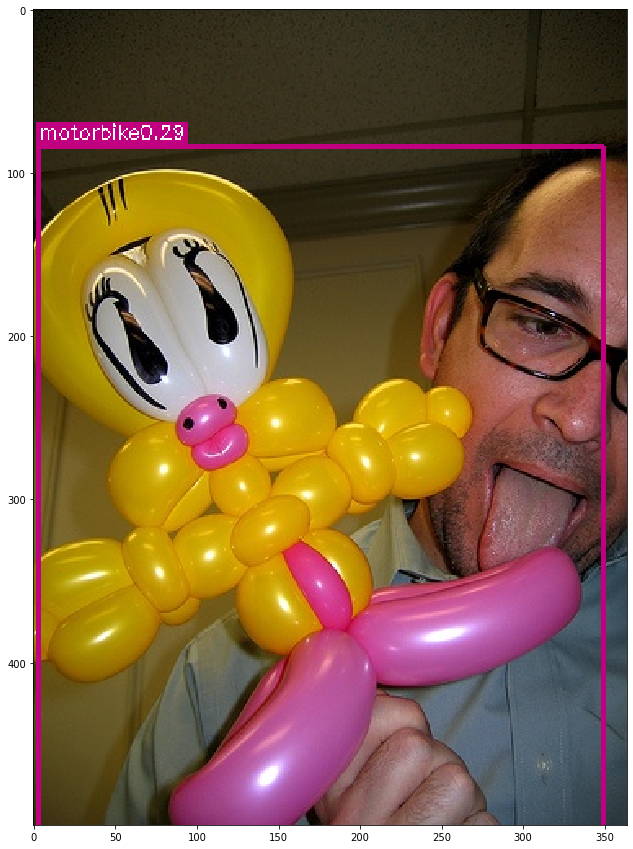

In [10]:
net.load_state
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [11]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [03:46<00:00, 21.83it/s]


---class aeroplane ap 0.4556808565262098---
---class bicycle ap 0.571102760828593---
---class bird ap 0.4629518112710673---
---class boat ap 0.23857389042576413---
---class bottle ap 0.2229034913962468---
---class bus ap 0.6019081600051615---
---class car ap 0.6532190908596617---
---class cat ap 0.723979971975444---
---class chair ap 0.3318727237174382---
---class cow ap 0.5384293957493729---
---class diningtable ap 0.3375129245325432---
---class dog ap 0.650630449243774---
---class horse ap 0.6561291826122814---
---class motorbike ap 0.5165683004277439---
---class person ap 0.5158192929779994---
---class pottedplant ap 0.1729299110077707---
---class sheep ap 0.5093145795823486---
---class sofa ap 0.4615359144113982---
---class train ap 0.6152693257139461---
---class tvmonitor ap 0.47676348884181674---
---map 0.48565477610532903---


In [12]:
output_submission_csv('detach_my_solution.csv', test_aps)